In [98]:
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
#start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
#warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')


In [17]:
#take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [13]:
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [18]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


# Class imbalance:

In [19]:
x=train.iloc[:,2:].sum()

#marking comments without any tags as "clean"

rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

#count number of clean entries

train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [20]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)

print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


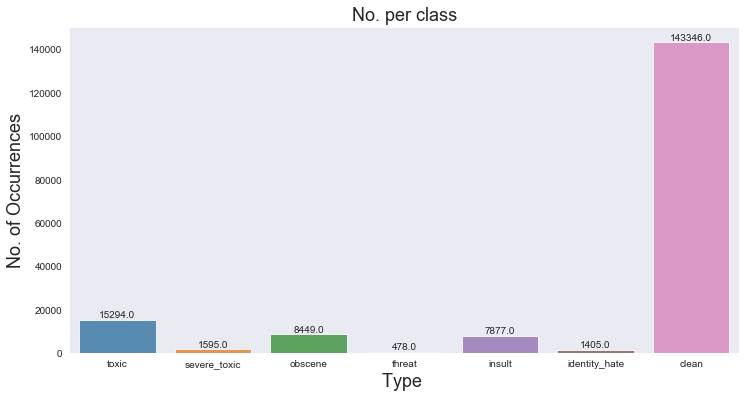

In [30]:
x=train.iloc[:,2:].sum()

#plot

plt.figure(figsize=(12,6))
axis= sns.barplot(x.index, x.values, alpha=0.8)

plt.title("No. per class", fontsize=18)
plt.ylabel('No. of Occurrences', fontsize=18)
plt.xlabel('Type ', fontsize=18)

#adding the text labels

rects = axis.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axis.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Multi-tagging:
    How many comments have multiple tags

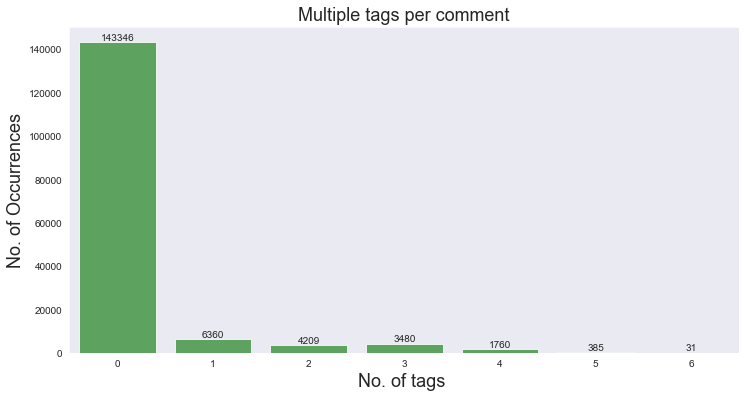

In [31]:
x=rowsums.value_counts()

#rowsums --> used in finding clean comments

#plot

plt.figure(figsize=(12,6))
axis = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])

plt.title("Multiple tags per comment",fontsize=18)
plt.ylabel('No. of Occurrences', fontsize=18)
plt.xlabel('No. of tags ', fontsize=18)

#adding the text labels
rects = axis.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axis.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Which tags go together?
Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

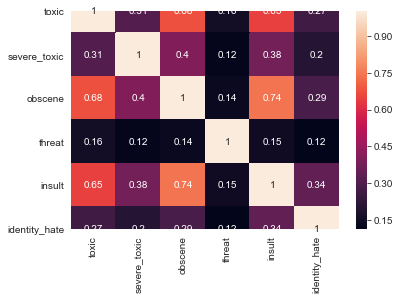

In [43]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments


corr=temp_df.corr()
plt.figure()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [50]:
# https://pandas.pydata.org/pandas-docs/stable/style.html

def highlight_min(data, color='pink'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [51]:
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [54]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]     #uses scipy.stats
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    
    r,k = confusion_matrix.shape
    
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [58]:
#Checking for Toxic and Severe toxic

col1="toxic"
col2="severe_toxic"

confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])

print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)

new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


# Example comments:

In [68]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


In [72]:
print("toxic:")
print()
print(train[train.toxic==1].iloc[1,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [83]:
print("Severe toxic:")
print()
print(train[train.severe_toxic==1].iloc[3,1])

Severe toxic:

Hi 

Im a fucking bitch.

50.180.208.181


In [73]:
print("Obscene:")
print()
print(train[train.obscene==1].iloc[1,1])

Obscene:

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [74]:
print("Threat:")
print()
print(train[train.threat==1].iloc[1,1])

Threat:

I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [81]:
print("Insult:")
print()
print(train[train.insult==1].iloc[1,1])

Insult:

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [78]:
print("Identity hate:")
print()
print(train[train.identity_hate==1].iloc[4,1])

Identity hate:

u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# That was a whole lot of toxicity. Some weird observations:

Some of the comments are extremely and mere copy paste of the same thing. (OVERFITTING)
Comments can still contain IP addresses(eg:50.180.208.181), usernames(eg:ARKJEDI10) and some mystery numbers(i assume is article-IDs)

# Wordclouds - Frequent words:
Now, let's take a look at words that are associated with these classes.

Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics involves the following steps.

* Search for an image and its base 64 encoding
* Paste encoding in a cell and convert it using codecs package to image
* Create word cloud with the new image as a mask

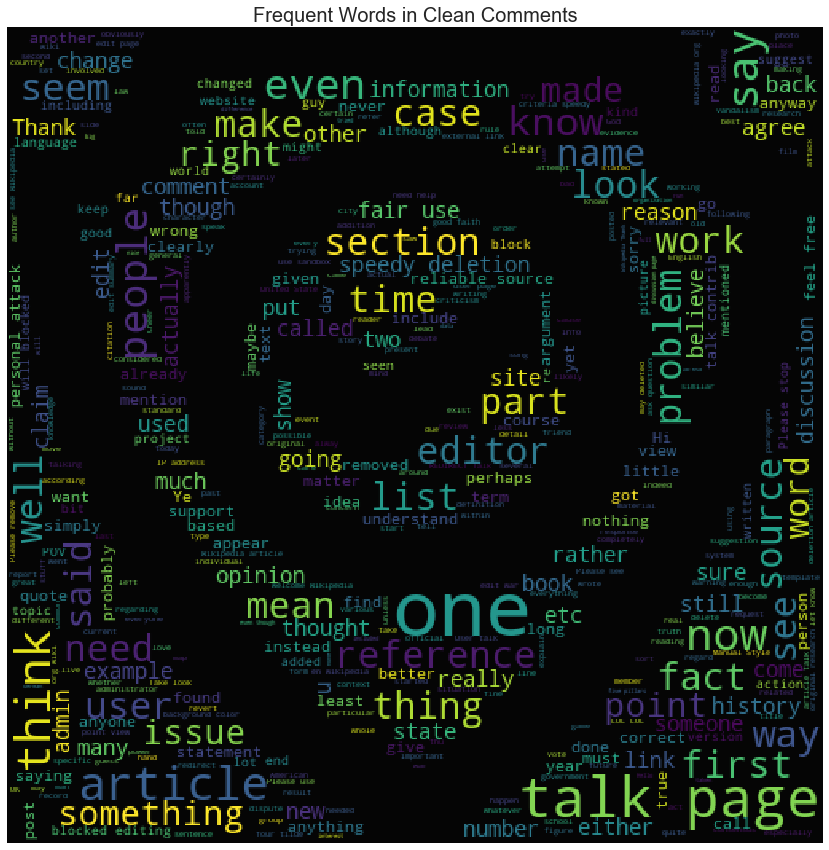

In [116]:
clean_mask=np.array(Image.open("safe-zone.png"))
clean_mask=clean_mask[:,:,1]

#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",mask=clean_mask,max_words=2000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Frequent Words in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

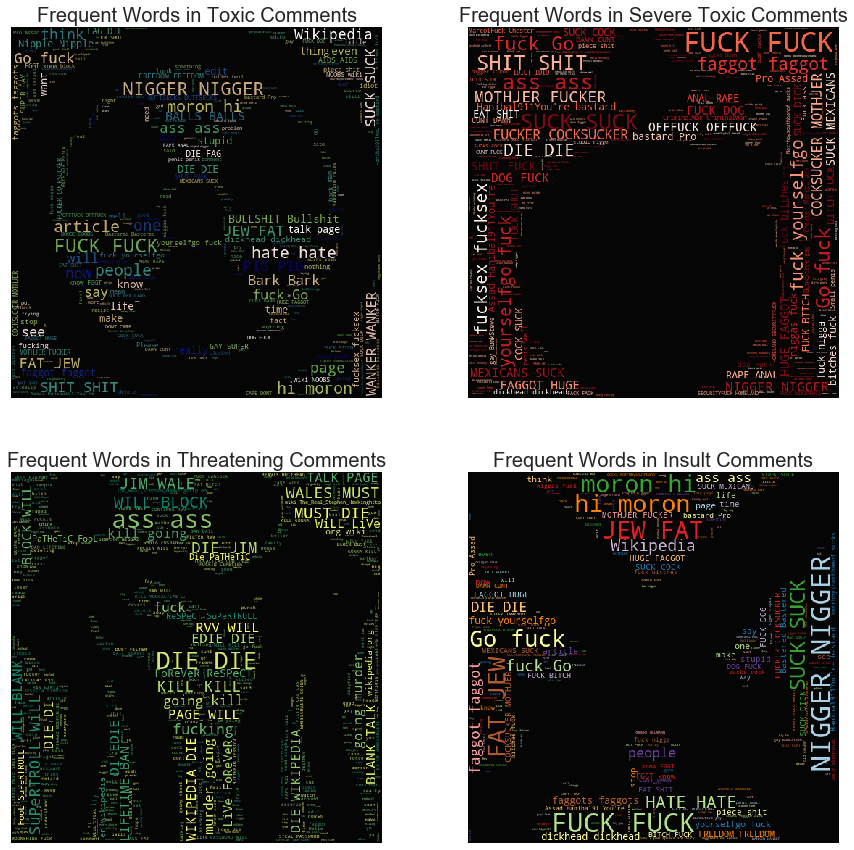

In [118]:
toxic_mask=np.array(Image.open("toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]

#wordcloud for toxic comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=toxic_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.axis("off")
plt.title("Frequent Words in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=17), alpha=0.98)
           
#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Frequent Words in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=17), alpha=0.98)


#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Frequent Words in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=17), alpha=0.98)


#insult
plt.subplot(224)
insult_mask=np.array(Image.open("swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Frequent Words in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
plt.show()
